#QSVM Classifier

In [ ]:
!pip install qiskit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.6 MB/s eta 0:00:00


Starting quantum SVM classifier...
Computing training kernel...
Fitting SVM...
Computing test kernel...
Predicting...
Quantum SVM Accuracy: 0.8718

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.86      1.00      0.93        32

    accuracy                           0.87        39
   macro avg       0.93      0.64      0.69        39
weighted avg       0.89      0.87      0.84        39



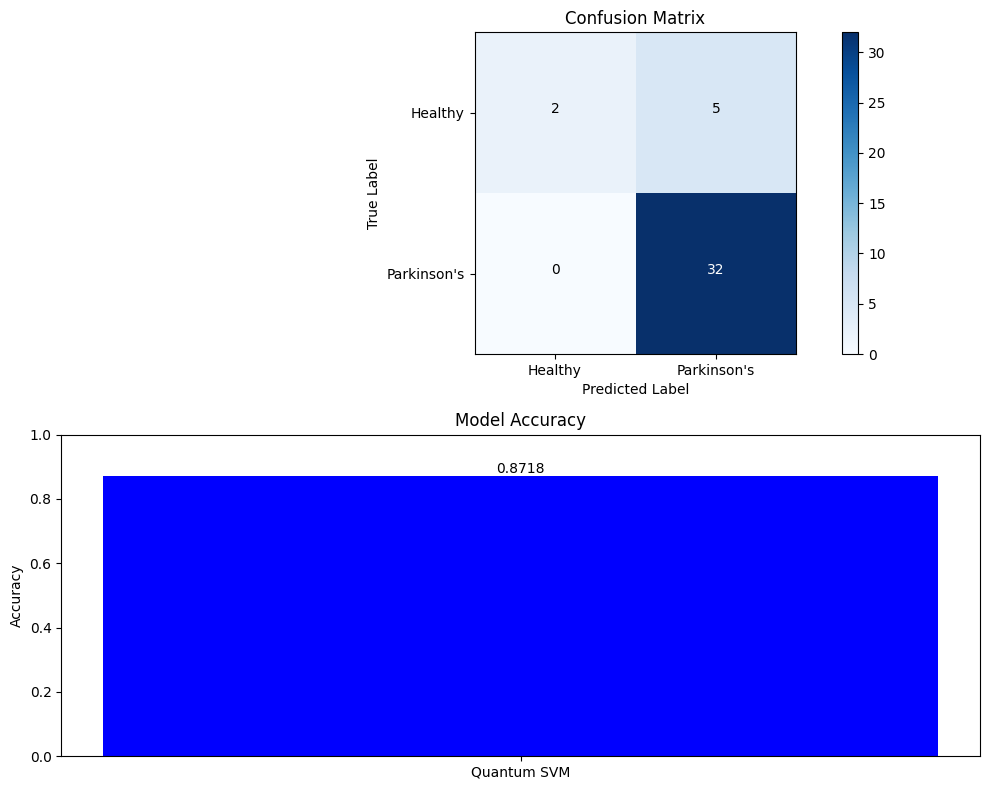

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Load the dataset
data = pd.read_csv('classification_dataset.data')

# Prepare the features and target
X = data.drop(['name', 'status'], axis=1)
y = data['status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reduce dimensionality even further (using only first 5 features)
X_train_reduced = X_train_scaled[:, :5]
X_test_reduced = X_test_scaled[:, :5]

# Use only a subset of the data for training (adjust this number based on your computational resources)
n_samples = 100
X_train_subset = X_train_reduced[:n_samples]
y_train_subset = y_train[:n_samples]

def quantum_svm_classifier(X_train, X_test, y_train, y_test):
    n_qubits = X_train.shape[1]

    feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=1)  # Reduced reps to 1

    quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

    qsvc = SVC(kernel='precomputed')

    print("Computing training kernel...")
    kernel_train = quantum_kernel.evaluate(X_train)
    print("Fitting SVM...")
    qsvc.fit(kernel_train, y_train)

    print("Computing test kernel...")
    kernel_test = quantum_kernel.evaluate(X_test, X_train)
    print("Predicting...")
    y_pred = qsvc.predict(kernel_test)

    accuracy = accuracy_score(y_test, y_pred)

    return qsvc, accuracy, y_pred

# Train and test the quantum SVM
print("Starting quantum SVM classifier...")
qsvm_model, qsvm_accuracy, y_pred = quantum_svm_classifier(X_train_subset, X_test_reduced, y_train_subset, y_test)

print(f"Quantum SVM Accuracy: {qsvm_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualization
plt.figure(figsize=(10, 8))

# Plot confusion matrix
plt.subplot(2, 1, 1)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Healthy', 'Parkinson\'s'])
plt.yticks(tick_marks, ['Healthy', 'Parkinson\'s'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

# Plot accuracy
plt.subplot(2, 1, 2)
plt.bar(['Quantum SVM'], [qsvm_accuracy], color='blue')
plt.title('Model Accuracy')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

for i, v in enumerate([qsvm_accuracy]):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()


# QSVM Regressor

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, mean_squared_error
from qiskit.circuit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

In [ ]:
# Load and preprocess data
def load_and_preprocess_data(file_path):
    data = pd.read_csv('Progression_Dataset.csv')
    X = data.drop(['subject#', 'motor_UPDRS', 'total_UPDRS'], axis=1)
    y_class = (data['total_UPDRS'] > data['total_UPDRS'].median()).astype(int)
    y_prog = data['total_UPDRS']
    return X, y_class, y_prog

# Feature selection
def select_features(X, y, k=10):
    selector = SelectKBest(f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    return X_selected, selected_features

# Classical Random Forest
def train_random_forest(X_train, y_train):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

# Quantum Kernel
def create_quantum_kernel(X_train):
    num_qubits = X_train.shape[1]
    feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2)
    #sampler = Sampler()
    quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)
    return quantum_kernel

In [ ]:
# Quantum SVM
def train_qsvm(quantum_kernel, X_train, y_train):
    qsvm = QSVC(quantum_kernel=quantum_kernel)
    qsvm.fit(X_train, y_train)
    return qsvm

In [ ]:
# Ensemble predictions
def ensemble_predict(rf_model, qsvm, X_test):
    rf_pred = rf_model.predict_proba(X_test)[:, 1]
    qsvm_pred = qsvm.predict(X_test)
    ensemble_pred = (rf_pred + qsvm_pred) / 2
    return (ensemble_pred > 0.5).astype(int)

In [ ]:
# Progression prediction
def train_progression_model(X_train, y_prog_train):
    prog_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    prog_model.fit(X_train, y_prog_train)
    return prog_model

In [ ]:
# Main function
def main():
    # Load and preprocess data
    X, y_class, y_prog = load_and_preprocess_data('Progression_Dataset.csv')
    X_selected, selected_features = select_features(X, y_class)

    # Split data
    X_train, X_test, y_class_train, y_class_test, y_prog_train, y_prog_test = train_test_split(
        X_selected, y_class, y_prog, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Random Forest
    rf_model = train_random_forest(X_train_scaled, y_class_train)

    # Create Quantum Kernel and train QSVM
    quantum_kernel = create_quantum_kernel(X_train_scaled)
    qsvm = train_qsvm(quantum_kernel, X_train_scaled, y_class_train)

    # Ensemble predictions
    ensemble_predictions = ensemble_predict(rf_model, qsvm, X_test_scaled)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_class_test, ensemble_predictions))

    # Train progression model
    prog_model = train_progression_model(X_train_scaled, y_prog_train)

    # Predict progression
    prog_predictions = prog_model.predict(X_test_scaled)
    mse = mean_squared_error(y_prog_test, prog_predictions)
    print(f"Progression Prediction MSE: {mse}")

if __name__ == "__main__":
    main()

Motor UPDRS - Mean Squared Error: 476.6103, R-squared Score: -6.8418
Total UPDRS - Mean Squared Error: 861.4831, R-squared Score: -7.7268


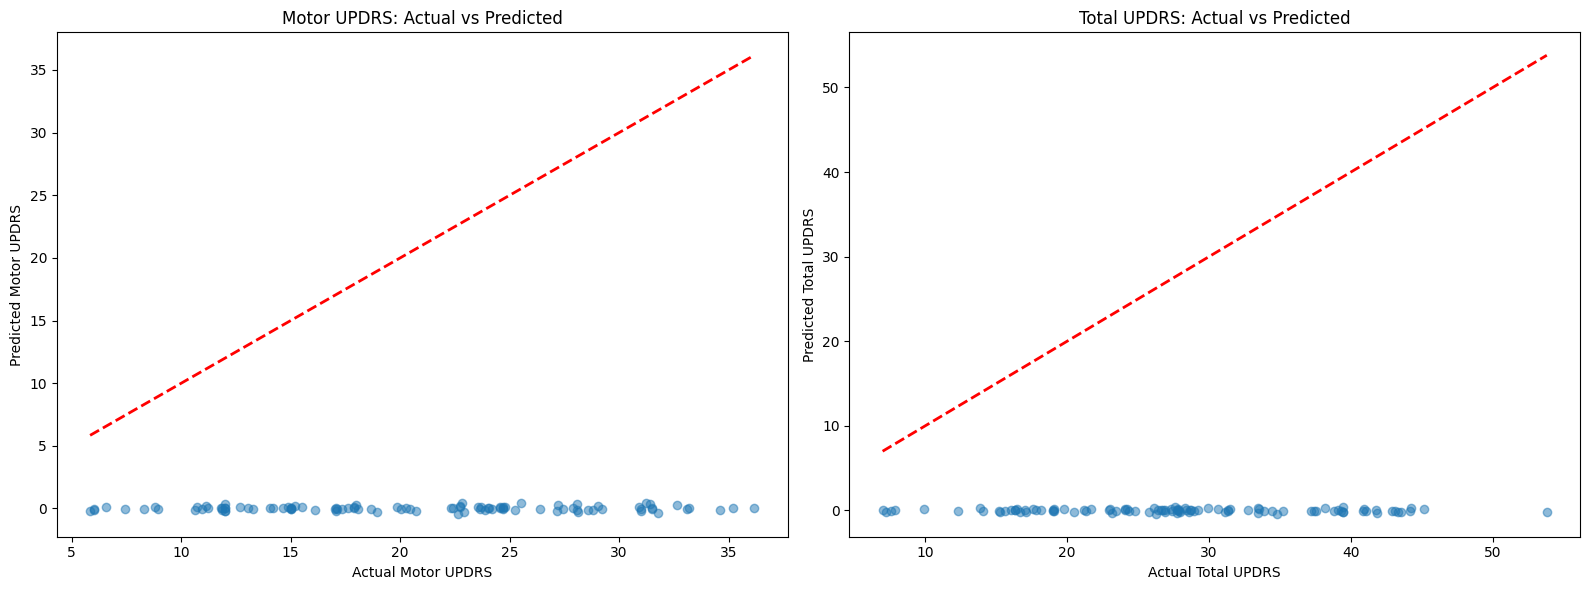

In [ ]:
print(f"Motor UPDRS - Mean Squared Error: {mse_motor:.4f}, R-squared Score: {r2_motor:.4f}")
print(f"Total UPDRS - Mean Squared Error: {mse_total:.4f}, R-squared Score: {r2_total:.4f}")

# Visualization (reduced to only essential plots)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(y_motor_test, y_motor_pred, alpha=0.5)
ax1.plot([y_motor_test.min(), y_motor_test.max()], [y_motor_test.min(), y_motor_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Motor UPDRS')
ax1.set_ylabel('Predicted Motor UPDRS')
ax1.set_title('Motor UPDRS: Actual vs Predicted')

ax2.scatter(y_total_test, y_total_pred, alpha=0.5)
ax2.plot([y_total_test.min(), y_total_test.max()], [y_total_test.min(), y_total_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Total UPDRS')
ax2.set_ylabel('Predicted Total UPDRS')
ax2.set_title('Total UPDRS: Actual vs Predicted')

plt.tight_layout()
plt.show()